# Physics-informed-DeepONet: Example 9

Now we want to train the PI-DeepONet variant, where no solution data is needed. On Google colab this approach is not feasible for problems with multiple higher order derivatives, because it becomes too memory and computational expensive. Because of this, we switch to a simple ODE:

\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } [0, 1] \\
    u(0) &= 0
\end{align*}

This ODE will guide us through the implementation and gives a simple introduction to PI-DeepONets. Our goal is to learn the operator that maps the parameter function $f$ to the solution $u$.

First, we have to install the library:

In [1]:
!pip install torchaudio==0.13.0
!pip install torchvision==0.14.0
!pip install torchphysics

import torch
import torchphysics as tp
import pytorch_lightning as pl

In [2]:
# Spaces 
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable
K = tp.spaces.R1('k') # parameter
F = tp.spaces.R1('f') # function output space name
# Domains
T_int = tp.domains.Interval(T, 0, 1)
K_int = tp.domains.Interval(K, 0, 6) # Parameters to sample f will be scalar values
# Defining the FunctionSpace
Fn_space = tp.spaces.FunctionSpace(T_int, F)

We will consider three different types of function types for $f$. These are:
\begin{align*}
    f_1(t) &= k t\\
    f_2(t) &= k t^2\\
    f_3(t) &= k \cos{(k t)}
\end{align*}
Here, $k$ is a random parameter that lead to different slopes and amplitude.

In [3]:
def f1(k, t):
    return k*t

def f2(k, t):
    return k*t**2

def f3(k, t):
    return k*torch.cos(k*t)

param_sampler = tp.samplers.RandomUniformSampler(K_int, n_points=80)

# Each function above represents a FunctionSet. From these sets we can sample in TorchPhysics
# different representatives for the right hand side of our ODE.
Fn_set_1 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f1)
# TODO: Complete the FunctionSet for f2 and f3
Fn_set_2 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f2) 
Fn_set_3 = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f3)

# With "+" we can construct the Union of these sets (this is not the sum of f1+f2+f3, but just the set union)
Fn_set = Fn_set_1 + Fn_set_2 + Fn_set_3 

Next is the DeepONet itself, the definition is the same as in the data driven case. Since our problem is now alot simpler, we can use a smaller network

In [4]:
# Since our input functions are now created on the fly and not given by data, we can
# use an arbitrary sampler to discretize them.
dis_sampler = tp.samplers.GridSampler(T_int, 50).make_static()

# TODO: Implement the a fully connected Trunk and Branchnet. The Trunk should have two hidden layers with
#       30 neurons each and the Branch two hidden layers with 50 neurons.
trunk_net = tp.models.FCTrunkNet(T, hidden=(30, 30))
branch_net = tp.models.FCBranchNet(Fn_space, hidden=(50, 50), 
                                   discretization_sampler=dis_sampler)
model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=50)

In [5]:
# TODO: Implement a time sampler for the ODE condition and the ODE residual (same as for PINNS)
ode_sampler = tp.samplers.RandomUniformSampler(T_int, 6000)

def ode_residual(u, t, f): 
    # The f is the function that was inputed in the Branch, but now evaluated
    # at the time points that are used in this condition.
    return tp.utils.grad(u, t) - f

# Here we now use the "PIDeepONetCondition" instead of the "PINNCondition", since
# we also have to handle the Branch-inputs.
ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             function_set=Fn_set, 
                                             input_sampler=ode_sampler, 
                                             name='ode_condition',
                                             residual_fn=ode_residual)

In [6]:
# The initial condition is also the same as in PINNs:
left_sampler = tp.samplers.RandomUniformSampler(T_int.boundary_left, 1000)

def initial_residual(u):
    return u

# TODO: Complete the "PIDeepONetCondition"
initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                                 function_set=Fn_set, 
                                                 input_sampler=left_sampler, 
                                                 name='initial_condition',
                                                 residual_fn=initial_residual)

This already finishes the PI-DeepONet implementation and we can start the training.

In [7]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([ode_cond, initial_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=4000,
                     )

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.2 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Switching to LBFGS, to further tune the network, is helpful in this problem:

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.4, 
                            optimizer_args={'max_iter':2, 'history_size': 100})

# Here, use grid of points, since LBFGS needs fixed inputs:
ode_cond.input_sampler = tp.samplers.GridSampler(T_int, n_points=4000).make_static()
initial_cond.input_sampler = initial_cond.input_sampler.make_static()
# Also fix parameters for input functions of the Branch:
Fn_set_1.parameter_sampler = Fn_set_1.parameter_sampler.make_static()
Fn_set_2.parameter_sampler = Fn_set_2.parameter_sampler.make_static()
Fn_set_3.parameter_sampler = Fn_set_3.parameter_sampler.make_static()


solver = tp.solver.Solver(train_conditions=[ode_cond, initial_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     max_steps=3000, 
                     benchmark=True,
                     logger=False, 
                     )
                     
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.2 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Check the accuracy of the learned integrator:

In [14]:
def F1(k, t):
    return k/2.0 * t**2

def F2(k, t):
    return k/3.0 * t**3

def F3(k, t):
    return torch.sin(k*t)

Plot one example for each f:


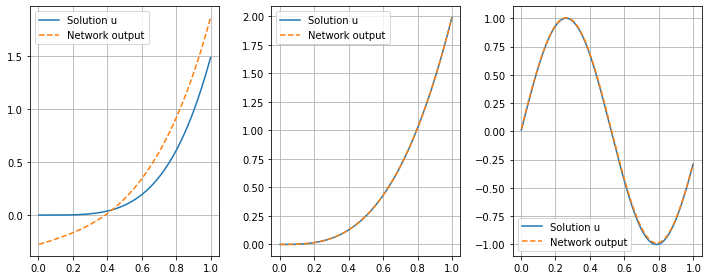

In [16]:
import matplotlib.pyplot as plt

k_test = 5.16

print("Plot one example for each f:")
plt.figure(figsize=(10, 4))


f = [f1, f2, f3]
F = [F1, F2, F3]

grid_sampler = tp.samplers.GridSampler(T_int, 500)
grid_points = grid_sampler.sample_points().as_tensor

for j in range(3):
    def f_helper(t):
        return f[j](k_test, t)
    
    plt.subplot(1, 3, j+1)
    plt.plot(grid_points, F[j](k_test, grid_points)) # plot the expected solution

    model.fix_branch_input(f_helper)
    out = model(tp.spaces.Points(grid_points, T)).as_tensor.detach()[0]
    plt.plot(grid_points, out, linestyle="--") # plot network output
    plt.grid()
    plt.legend(["Solution u", "Network output"])

plt.tight_layout()